In [1]:
# import findspark
import findspark
# initialize findspark with spark directory
findspark.init("C:\BigData\BigData\spark-3.1.2-bin-hadoop3.2")
# import pyspark
import pyspark
# create spark context
sc = pyspark.SparkContext()
# create spark session 
spark = pyspark.sql.SparkSession(sc)

In [2]:
# check
spark

In [300]:
# import packages
import os 
import pickle

import re
import time
import datetime
from datetime import datetime
import requests
import matplotlib.pyplot as plt 
import pytz
import emojis

import pandas as pd
import numpy as np
import ast

import pyspark.sql.functions as F
from pyspark.sql.types import *

from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
import tweepy
import csv
import pandas as pd
import os
import json
import plotly.express as px
from pandas.tseries.holiday import nearest_workday, \
    AbstractHolidayCalendar, Holiday, \
    USMartinLutherKingJr, USPresidentsDay, GoodFriday, \
    USMemorialDay, USLaborDay, USThanksgivingDay
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn import metrics

# 1. Import Data & Exploration

In [4]:
# import the data 
list_brands = ["healthyfood",
               "healthylifestyle",
               "vegan",
               "keto",
               "ketodiet",
               "ketolifestyle",
               "veganism",
               "vegetarian"]
from re import search



data_dir = ".././../data/Topic/"
tweet_files = [os.path.join(data_dir, obs) for obs in os.listdir(data_dir)]



files_brand = [file for file in tweet_files if (file.find(list_brands[2]) != -1)]
files_brand               
               
df_json = spark.read.option("multiline","true").json(files_brand)  
# df_json.count() = 1827680

In [5]:
# check the schema of our json dataframe
df_json.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

In [6]:
# select interesting features
df = df_json.select(F.col("user.name"),
                                F.col("user.screen_name"),
                                F.col("created_at"), 
                                F.col("full_text"),
                                F.col("entities.hashtags"),
                                F.col("lang"),
                                F.col("favorite_count"),
                                F.col("retweet_count"),
                                F.col("user.followers_count"),
                                F.col("user.friends_count"),
                                F.col("user.favourites_count"),
                                F.col("entities.urls"),
                                F.col("entities.symbols"))

# 2. Preprocess Data

## 2.1 Check Time Period 

In [7]:
# https://developer.twitter.com/en/docs/twitter-ads-api/timezones
# function to convert Twitter date string format
# define the function

def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

# UDF declaration
date_udf = F.udf(getDate, StringType())

# apply udf
df = df.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

In [449]:
# show
df.select("created_at", "post_created_at").show(5, truncate=False)

+------------------------------+-------------------+
|created_at                    |post_created_at    |
+------------------------------+-------------------+
|Tue Sep 13 22:32:32 +0000 2022|2022-09-13 22:32:32|
|Tue Sep 13 22:32:26 +0000 2022|2022-09-13 22:32:26|
|Tue Sep 13 22:32:26 +0000 2022|2022-09-13 22:32:26|
|Tue Sep 13 22:32:16 +0000 2022|2022-09-13 22:32:16|
|Tue Sep 13 22:32:09 +0000 2022|2022-09-13 22:32:09|
+------------------------------+-------------------+
only showing top 5 rows



In [109]:
# get first post
first_post = F.min('post_created_at').alias('earliest')
# get latest post
latest_post = F.max('post_created_at').alias('latest')
# show tweet period in our dataset
df.select(first_post, latest_post).show()

+-------------------+-------------------+
|           earliest|             latest|
+-------------------+-------------------+
|2021-10-25 07:19:40|2022-10-11 23:17:33|
+-------------------+-------------------+



In [8]:
#drop duplicates and retweets 
df = df.filter(~F.col("full_text").startswith("RT"))\
                        .drop_duplicates()
#sorting such when dropping later we only keep the most recent post 
df = df.sort("post_created_at", ascending=False)
#removing spam accounts 
df = df.drop_duplicates(["full_text", "screen_name"])

#df.printSchema()
#df.count() #1340938

## 2.2 Feature Engineering

In [9]:
# define function to count hashtags
def get_hashtags(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "#" in word:
            counter += 1
    return(counter)

In [10]:
# define function to count mentions
def get_mentions(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "@" in word:
            counter += 1
    return(counter)

In [11]:
# define function to count exclamation marks
def get_exclamation_marks(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "!" in word:
            counter += 1
    return(counter)

In [12]:
# define function to count number of emojis used
def emoji_counter(text):
    nr_emojis = emojis.count(text)
    return(nr_emojis)

In [13]:
# define function to calculate engagement rate
def engagement_rate(favorite_count, retweet_count, followers_count):
    if(followers_count == 0):
        eng_rate = 0
    else:
        eng_rate = (favorite_count + retweet_count)/followers_count
    
    return eng_rate

In [14]:
# register functions as udf
get_hashtags_UDF = F.udf(get_hashtags, IntegerType())
get_mentions_UDF = F.udf(get_mentions, IntegerType())
get_exclamation_marks_UDF = F.udf(get_exclamation_marks, IntegerType())
emoji_counter_UDF = F.udf(emoji_counter, IntegerType())
engagement_rate_UDF = F.udf(engagement_rate, DoubleType())

In [15]:
# apply functions to create new features
df = df.withColumn("emoji_count", emoji_counter_UDF("full_text")) \
        .withColumn("text_tokenized", F.split("full_text", " ")) \
        .withColumn("num_words", F.size("text_tokenized")) \
        .withColumn("num_hashtags", get_hashtags_UDF("text_tokenized")) \
        .withColumn("num_mentions", get_mentions_UDF("text_tokenized")) \
        .withColumn("num_exclamation_marks", get_exclamation_marks_UDF("text_tokenized")) \
        .withColumn("engagement_rate", engagement_rate_UDF("favorite_count", "retweet_count", "followers_count"))

In [117]:
# show
df.select("full_text", "emoji_count", "num_words", "num_hashtags", "num_mentions", "num_exclamation_marks", "engagement_rate").toPandas().tail(5)

,full_text,emoji_count,num_words,num_hashtags,num_mentions,num_exclamation_marks,engagement_rate
693927,@TheOnlyWarman @sourtimbits Not sure about tha...,0,21,0,2,0,0.000000
693928,"@MontielRene ""El mae que come en restaurante v...",1,12,0,1,0,0.000000
693929,@wolfje220560 @HermanB86871141 @h3l33nboS @Car...,3,30,0,5,1,0.003268
693930,Uptick of positive veganism takes on the TL fr...,0,15,0,0,0,0.010124
693931,"Wow! Busy morning, thank you! 😃\nLive music th...",2,37,6,0,3,0.000861


# 3. Text Cleaning 

In [16]:
# filter for english tweets (NOTE: for the assignment you can translate non-english tweets using an API)
df = df.filter(F.col("lang") == "en")

In [42]:
# check number of observations
df.count()

469429

In [17]:
# define function to clean text
def clean_text(string):
    
    # define numbers
    NUMBERS = '0123456789'
    PUNCT = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    
    # convert text to lower case
    cleaned_string = string.lower()
    
    # remove URLS
    cleaned_string = re.sub(r'http\S+', ' ', cleaned_string)
    
    # replace emojis by words
    cleaned_string = emojis.decode(cleaned_string)
    cleaned_string = cleaned_string.replace(":"," ").replace("_"," ")
    cleaned_string = ' '.join(cleaned_string.split())
    
    # remove numbers
    cleaned_string = "".join([char for char in cleaned_string if char not in NUMBERS])
    
    # remove punctuation
    cleaned_string = "".join([char for char in cleaned_string if char not in PUNCT])
    
    # remove words conisting of one character (or less)
    cleaned_string = ' '.join([w for w in cleaned_string.split() if len(w) > 1])
    
    # return
    return(cleaned_string)

In [18]:
# convert to udf
clean_text_udf = F.udf(clean_text, StringType())

In [19]:
# clean string
df = df.withColumn("cleaned_text", clean_text_udf(F.col("full_text")))

In [128]:
# check
pd.set_option('display.max_colwidth', None)
df.select("full_text", "cleaned_text").limit(5).toPandas()

,full_text,cleaned_text
0,"""A lot of people say they can't eat vegan, but I'm just like them – and if I can do it they can do it."" Nichole Lewis who is a 26-year-old mom lost 120 pounds and improved her #mentalhealth by eating a plant-based diet. Here are her weight loss secrets: https://t.co/4RAT8rwqTO",lot of people say they cant eat vegan but im just like them and if can do it they can do it nichole lewis who is yearold mom lost pounds and improved her mentalhealth by eating plantbased diet here are her weight loss secrets
1,"""By now, your [vegan/vegetarian] lifestyle may be so easy to maintain that you don't even have to think about it...All of this can change when you study abroad."" Check out Hannah's tips on staying vegan while abroad: https://t.co/fIy45ntvTD",by now your veganvegetarian lifestyle may be so easy to maintain that you dont even have to think about itall of this can change when you study abroad check out hannahs tips on staying vegan while abroad
2,"""Don't stay in the sun""\n""Use sunscreen""\n""Red meat is bad for you""\n""Vegan diet is healthy""\n""Seed oil is healthy""\n""Inflation is a good thing""\n""#Bitcoin is bad for the enviroment""\n\nWhat other things does the media portray as positive while being extremely damaging?",dont stay in the sun use sunscreen red meat is bad for you vegan diet is healthy seed oil is healthy inflation is good thing bitcoin is bad for the enviroment what other things does the media portray as positive while being extremely damaging
3,"""Heroes sacrifice for causes; they do things that others hide from. I may not be some great hero, but I won't hide from this"" - Brandon Mull.\n#Antispeciesism \n#Animalliberation \n#Vegan\n#Love https://t.co/1hK7FXsgRo",heroes sacrifice for causes they do things that others hide from may not be some great hero but wont hide from this brandon mull antispeciesism animalliberation vegan love
4,"""Last year over a million people left the same suicide note... SHOPPING LIST: Butter, Eggs, Milk, Cheese, Beef, Chicken, and Bacon."" - Physicians Committee for Responsible Medicine\n#vegan",last year over million people left the same suicide note shopping list butter eggs milk cheese beef chicken and bacon physicians committee for responsible medicine vegan


# 4. Sentiment 

## 4.1 The Vader Package

VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text.

In [20]:
#using the vaderSentiment package 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [21]:
# define the function to extract the sentiment
def get_sentiment(sentence):

    # initialize sentiment analyzer
    sid_obj = SentimentIntensityAnalyzer()

    # get sentiment dict
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    # get positive sentiment score
    pos_sentiment = sentiment_dict["pos"]
    
    # return positive sentiment score
    return(pos_sentiment)

get_sentiment_udf = udf(get_sentiment, DoubleType())

In [22]:
df = df.withColumn("sentiment_vader", get_sentiment_udf(F.col("cleaned_text")))

In [153]:
df.select("cleaned_text", "sentiment_vader").show()

+--------------------+---------------+
|        cleaned_text|sentiment_vader|
+--------------------+---------------+
|lot of people say...|          0.139|
|by now your vegan...|          0.094|
|dont stay in the ...|            0.2|
|heroes sacrifice ...|          0.321|
|last year over mi...|          0.075|
|monday mint motiv...|          0.098|
|no nut november m...|          0.238|
|sir why did you s...|          0.263|
|there are many go...|          0.114|
|vegan diets provi...|          0.314|
|we were given veg...|           0.16|
|why are vegans so...|          0.164|
|would you ever go...|            0.0|
|you doing anythin...|          0.172|
|defeating russia ...|            0.0|
|sustainabledecisi...|          0.061|
|arfeatures cai st...|            0.0|
|bgan punks are no...|            0.0|
|cbdoil for anxiet...|          0.372|
|didyouknow as lon...|            0.0|
+--------------------+---------------+
only showing top 20 rows



## 4.2 TextBlob Package 

TextBlob returns polarity and subjectivity of a sentence. 

**Polarity** lies between [-1,1],  -1 defines a negative sentiment and 1 defines a positive sentiment.  

**Subjectivity** quantifies the amount of personal opinion and factual information contained in the text. Subjectivity lies between [0,1]. The higher subjectivity means that the text contains personal opinion rather than factual information. 

In [23]:
#use polarity and subjectivity from TextBlob 
#https://textblob.readthedocs.io/en/dev/
from textblob import TextBlob

In [24]:
# define function to get polarity score of text document
def get_polarity(row):
    textBlob_review = TextBlob(row)
    return textBlob_review.sentiment[0]
# define function to get subjectivity score of text document
def get_subjectivity(row):
    textBlob_review = TextBlob(row)
    return textBlob_review.sentiment[1]
get_polarity_udf = F.udf(get_polarity, DoubleType())
get_subjectivity_udf = F.udf(get_subjectivity, DoubleType())

In [25]:
df = df.withColumn('polarity', get_polarity_udf(F.col('cleaned_text')))\
        .withColumn('subjectivity', get_subjectivity_udf(F.col('cleaned_text')))

In [157]:
df.select("cleaned_text", "sentiment_vader", "polarity", "subjectivity").show()

+--------------------+---------------+--------------------+-------------------+
|        cleaned_text|sentiment_vader|            polarity|       subjectivity|
+--------------------+---------------+--------------------+-------------------+
|lot of people say...|          0.139|                 0.0|                0.0|
|by now your vegan...|          0.094| 0.43333333333333335| 0.8333333333333334|
|dont stay in the ...|            0.2|0.030808080808080826| 0.5393097643097643|
|heroes sacrifice ...|          0.321|                0.65|              0.675|
|last year over mi...|          0.075|-0.07999999999999999| 0.3383333333333333|
|monday mint motiv...|          0.098|                 0.0|                0.0|
|no nut november m...|          0.238|            0.221875|0.47187500000000004|
|sir why did you s...|          0.263|  0.6166666666666667| 0.4666666666666666|
|there are many go...|          0.114|  0.2785714285714286|               0.55|
|vegan diets provi...|          0.314|  

# 5. Basetable 

In [26]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- friends_count: long (nullable = true)
 |-- favourites_count: long (nullable = true)
 |-- urls: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- display_url: string (nullable = true)
 |    |    |-- expanded_url: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- url: string (nullable = true)


## 5.1 Adjust dates to opening hours stock exchange

First look at how many dates appear in our dataframe before adjusting the dates

In [27]:
def date_check(tweet_date):
    tweet_date = pd.to_datetime(tweet_date)
    return tweet_date.date()

In [28]:
date_check_udf = udf(date_check, DateType())
df = df.withColumn('date_check', date_check_udf(F.col('created_at')))

In [132]:
date_count = df.select(F.countDistinct("date_check"))
date_count.show()

+--------------------------+
|count(DISTINCT date_check)|
+--------------------------+
|                       232|
+--------------------------+



The class below contains all the official holidays where the stockmarket is closed, this is needed to be able to assign the tweets that are posted on a holiday, to the next day

In [29]:
import datetime

In [30]:
class USTradingHolidaysCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday(
            'NewYearsDay',
            month=1,
            day=1,
            observance=nearest_workday
        ),
        USMartinLutherKingJr,
        USPresidentsDay,
        GoodFriday,
        USMemorialDay,
        Holiday(
            'Juneteenth National Independence Day',
            month=6,
            day=19,
            start_date='2021-06-18',
            observance=nearest_workday,
        ),
        Holiday(
            'USIndependenceDay',
            month=7,
            day=4,
            observance=nearest_workday
        ),
        USLaborDay,
        USThanksgivingDay,
        Holiday(
            'Christmas',
            month=12,
            day=25,
            observance=nearest_workday
        ),
    ]

This function calls the US holidays class and checks whether the tweet was posted on an holiday on which the stock market was closed. If this is the case the tweet is assigned to the next day that's not a holiday or weekend

In [31]:
def check_holidays(tweet_date):
    # get the holidays for the periods when the tweets where placed 
    cal = USTradingHolidaysCalendar()
    holidays = cal.holidays(start='2021-10-11', end='2022-10-12')
    tweet_date = pd.to_datetime(tweet_date)
    # if the tweet is placed on a holiday, the tweet will be assigned to the next day that's not in the weekend
    if(tweet_date in holidays):
        tweet_date = tweet_date + datetime.timedelta(days = 1)
        if(tweet_date.isoweekday() == 6):
            tweet_date = tweet_date + datetime.timedelta(days = 2)
        elif(tweet_date.isoweekday() == 6):
            tweet_date = tweet_date + datetime.timedelta(days = 1)
    return tweet_date

This function takes the opening hours of the stock exchange into account for the tweets. When a tweet is posted before the opening hours of the stock market, the tweet is assigned to the day iself. When a tweet is posted the monday, tuesday, wednesday or thursday after the opening hours it is assigned to the next day. When a tweet is posted on friday after the openingshours it is assigned to monday. As well as if the tweet was posted on a saturday or sunday. 

The case when a tweet is posted after the opening hours on friday is a special case in our code. When it goes throug the first if else it will be assigned to the next day, so to saturday. Than when it goes to the second if it is assigned to the monday

In [32]:
def opening_hours(tweet_date):
    tweet_date = pd.to_datetime(tweet_date)
    open_NYSE = tweet_date.replace(hour=14, minute=30, second=0, microsecond=0)
    close_NYSE = tweet_date.replace(hour=21, minute=0, second=0, microsecond=0)
    # if the tweet is posted before the opening hours of the stock market, it is assigned to the next day
    if (tweet_date < open_NYSE):
        dependent_date = tweet_date.date()
    # else when the tweet is posted after the opening hours, it is assigned to the next day
    else:
        dependent_date = tweet_date.date()
        dependent_date = dependent_date + datetime.timedelta(days = 1)
    # if the tweet is posted on a saturday, it is assigned to the next monday
    if (dependent_date.isoweekday() == 6):
        dependent_date = dependent_date + datetime.timedelta(days = 2)
    # if the tweet is posted on a sunday, it is assigned to the next monday 
    if (dependent_date.isoweekday() == 7):
        dependent_date = dependent_date + datetime.timedelta(days = 1)
    return dependent_date

Now we will apply the functions on the dataset

In [33]:
opening_hours_udf = udf(opening_hours, DateType())
check_holidays_udf = udf(check_holidays, DateType())
df = df.withColumn('date_with_holidays', opening_hours_udf(F.col('created_at')))
df = df.withColumn('date', check_holidays_udf(F.col('date_with_holidays')))

In [161]:
date_count_after = df.select(F.countDistinct("date"))
date_count_after.show()

+--------------------+
|count(DISTINCT date)|
+--------------------+
|                 165|
+--------------------+



## 5.2 Dependent Variable

Import the stock information

In [34]:
stock_information = pd.read_excel("./../../data/stock_information.xlsx")

Here we create the dependent, which is the percentage of change compared to yesterday

In [35]:
stock_information["close_yesterday"] = stock_information["close"].shift(1)
#stock_information = stock_information[stock_information.date != "2021-10-11"]
stock_information["dependent"] = (stock_information["close"] - stock_information["close_yesterday"])/stock_information["close_yesterday"]
display(stock_information)

,symbol,date,open,high,low,close,volume,adjusted,close_yesterday,dependent
0,VEGN,2021-10-11,40.020000,40.161999,39.759998,39.759998,5000,39.524410,NaN,NaN
1,VEGN,2021-10-12,39.840000,39.840000,39.669998,39.724998,4900,39.489620,39.759998,-0.000880
2,VEGN,2021-10-13,40.070000,40.099998,39.810001,39.924000,16000,39.687439,39.724998,0.005009
3,VEGN,2021-10-14,40.340000,40.765999,40.340000,40.765999,3100,40.524448,39.924000,0.021090
4,VEGN,2021-10-15,41.060001,41.150002,41.060001,41.122002,1700,40.878345,40.765999,0.008733
...,...,...,...,...,...,...,...,...,...,...
248,VEGN,2022-10-05,31.469999,31.628000,31.120001,31.628000,1800,31.628000,31.719999,-0.002900
249,VEGN,2022-10-06,31.559999,31.600000,31.309999,31.309999,1200,31.309999,31.628000,-0.010054
250,VEGN,2022-10-07,30.299999,30.299999,30.180000,30.239000,1300,30.239000,31.309999,-0.034206
251,VEGN,2022-10-10,30.350000,30.350000,29.629999,29.830000,4500,29.830000,30.239000,-0.013526


This is a function that creates a binary variable. The variable will be 0 if the etf decreased or stayed on the same level, and will be 1 if the etf increased

In [36]:
def make_dependent(x):
    if x > 0:
        x = 1
    else:
        x = 0
    return x

Apply the function on the data

In [37]:
stock_information["dependent"] = stock_information["dependent"].apply(lambda x: make_dependent(x))
display(stock_information)

,symbol,date,open,high,low,close,volume,adjusted,close_yesterday,dependent
0,VEGN,2021-10-11,40.020000,40.161999,39.759998,39.759998,5000,39.524410,NaN,0
1,VEGN,2021-10-12,39.840000,39.840000,39.669998,39.724998,4900,39.489620,39.759998,0
2,VEGN,2021-10-13,40.070000,40.099998,39.810001,39.924000,16000,39.687439,39.724998,1
3,VEGN,2021-10-14,40.340000,40.765999,40.340000,40.765999,3100,40.524448,39.924000,1
4,VEGN,2021-10-15,41.060001,41.150002,41.060001,41.122002,1700,40.878345,40.765999,1
...,...,...,...,...,...,...,...,...,...,...
248,VEGN,2022-10-05,31.469999,31.628000,31.120001,31.628000,1800,31.628000,31.719999,0
249,VEGN,2022-10-06,31.559999,31.600000,31.309999,31.309999,1200,31.309999,31.628000,0
250,VEGN,2022-10-07,30.299999,30.299999,30.180000,30.239000,1300,30.239000,31.309999,0
251,VEGN,2022-10-10,30.350000,30.350000,29.629999,29.830000,4500,29.830000,30.239000,0


In [38]:
basetable_dep = stock_information[['date', 'dependent']]
basetable_dep.head()

,date,dependent
0,2021-10-11,0
1,2021-10-12,0
2,2021-10-13,1
3,2021-10-14,1
4,2021-10-15,1


## 5.3 Select Features and Group By Date

In [39]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- friends_count: long (nullable = true)
 |-- favourites_count: long (nullable = true)
 |-- urls: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- display_url: string (nullable = true)
 |    |    |-- expanded_url: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- url: string (nullable = true)


Features:
- number_tweets
- favorite_count 
- retweet_count 
- followers_count
- engagement_rate
- emoji_count
- num_words
- num_hashtags
- num_mentions
- num_exclamation_marks
- sentiment_vader
- polarity
- subjectivity

We will group the features per date, so we can merge the dataset with the dependent. For the first feature we look at how many tweets are posted on one day, the second one looks at the total number of favorites for all tweets on a day, the third one does the same for the number of retweets , the fourth one does the same for the number of followers and the fifth one does the same for the engagement. For all the other features the average is used as group function. This is because the first five features are more related to the network an the amount of people that are being reached on a certain day. While the other feature are more related to the tweets and what's expressed in these tweets

First we will only select the features

In [40]:
# select interesting features
df = df.select(F.col("date"),
                F.col("full_text"),
                F.col("favorite_count"),
                F.col("retweet_count"), 
                F.col("followers_count"),
                F.col("engagement_rate"),
                F.col("emoji_count"),
                F.col("num_words"),
                F.col("num_hashtags"),
                F.col("num_mentions"),
                F.col("num_exclamation_marks"),
                F.col("sentiment_vader"),
                F.col("polarity"),
                F.col("subjectivity"))

In [41]:
df.printSchema()

root
 |-- date: date (nullable = true)
 |-- full_text: string (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- engagement_rate: double (nullable = true)
 |-- emoji_count: integer (nullable = true)
 |-- num_words: integer (nullable = false)
 |-- num_hashtags: integer (nullable = true)
 |-- num_mentions: integer (nullable = true)
 |-- num_exclamation_marks: integer (nullable = true)
 |-- sentiment_vader: double (nullable = true)
 |-- polarity: double (nullable = true)
 |-- subjectivity: double (nullable = true)



In [42]:
number_of_tweets = df.groupBy('date').agg(F.countDistinct("full_text"))\
                    .withColumnRenamed("count(full_text)", "number_tweets") 

In [43]:
number_of_favorites = df.groupBy('date').agg(F.sum("favorite_count"))\
                        .withColumnRenamed("sum(favorite_count)", "number_of_favorites") 

In [44]:
number_of_retweets = df.groupBy('date').agg(F.sum("retweet_count"))\
                        .withColumnRenamed("sum(retweet_count)", "number_of_retweets") 

In [45]:
number_of_followers = df.groupBy('date').agg(F.sum("followers_count"))\
                        .withColumnRenamed("sum(followers_count)", "number_of_followers") 

In [46]:
avg_emojis = df.groupBy('date').agg(F.avg("emoji_count"))\
                        .withColumnRenamed("avg(emoji_count)", "avg_emojis") 

In [47]:
avg_words = df.groupBy('date').agg(F.avg("num_words"))\
                        .withColumnRenamed("avg(num_words)", "avg_words") 

In [48]:
avg_hashtags = df.groupBy('date').agg(F.avg("num_hashtags"))\
                        .withColumnRenamed("avg(num_hashtags)", "avg_hashtags") 

In [49]:
avg_num_mentions = df.groupBy('date').agg(F.avg("num_mentions"))\
                        .withColumnRenamed("avg(num_mentions)", "avg_num_mentions") 

In [50]:
avg_exclamation_marks = df.groupBy('date').agg(F.avg("num_exclamation_marks"))\
                        .withColumnRenamed("avg(num_exclamation_marks)", "avg_exclamation_marks") 

In [51]:
sum_engagement_rate = df.groupBy('date').agg(F.sum("engagement_rate"))\
                        .withColumnRenamed("sum(engagement_rate)", "sum_engagement_rate") 

In [52]:
avg_sentiment_vader = df.groupBy('date').agg(F.avg("sentiment_vader"))\
                        .withColumnRenamed("avg(sentiment_vader)", "sentiment_vader") 

In [53]:
avg_polarity = df.groupBy('date').agg(F.avg("polarity"))\
                        .withColumnRenamed("avg(polarity)", "avg_polarity") 

In [54]:
avg_subjectivity = df.groupBy('date').agg(F.avg("subjectivity"))\
                        .withColumnRenamed("avg(subjectivity)", "avg_subjectivity") 

Join al the features

In [298]:
# create basetable
basetable_ind = number_of_tweets.join(number_of_favorites, "date", how="inner") \
                    .join(number_of_retweets, "date", how="inner") \
                    .join(number_of_followers, "date", how="inner") \
                    .join(avg_emojis, "date", how="inner") \
                    .join(avg_words, "date", how="inner") \
                    .join(avg_hashtags, "date", how="inner") \
                    .join(avg_num_mentions, "date", how="inner") \
                    .join(avg_exclamation_marks, "date", how="inner") \
                    .join(sum_engagement_rate, "date", how="inner") \
                    .join(avg_sentiment_vader, "date", how="inner") \
                    .join(avg_polarity, "date", how="inner") \
                    .join(avg_subjectivity, "date", how="inner") 
basetable_ind_pd = basetable_ind.toPandas()

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "C:\BigData\BigData\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\worker.py", line 584, in main
  File "C:\BigData\BigData\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\serializers.py", line 562, in read_int
    length = stream.read(4)
  File "C:\Users\vikto\anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
socket.timeout: timed out


In [210]:
basetable_ind_pd.head()

,date,number_tweets,number_of_favorites,number_of_retweets,number_of_followers,avg_emojis,avg_words,avg_hashtags,avg_num_mentions,avg_exclamation_marks,avg_engagement_rate,polarity,avg_polarity,avg_subjectivity
0,2022-03-28,1952,18533,6313,19476231,0.821721,24.459529,5.600410,0.483607,0.367828,0.027125,0.188467,0.188467,0.419846
1,2022-07-31,3788,30457,3678,32478823,0.440514,24.518344,1.234801,0.995021,0.203354,0.039405,0.108215,0.108215,0.409116
2,2022-08-02,8160,72537,8321,89026921,0.450092,23.463042,1.089188,0.892731,0.225535,0.034250,0.121545,0.121545,0.413700
3,2022-05-26,434,3965,1285,1658594,0.838710,25.179724,5.912442,0.682028,0.400922,0.024796,0.211336,0.211336,0.416348
4,2022-06-22,1060,9382,3070,4919891,0.677358,25.031132,6.488679,0.459434,0.384906,0.026959,0.213542,0.213542,0.428171


In [213]:
type(basetable_ind_pd['date'][0])

datetime.date

In [491]:
type(basetable_dep['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

Cast the date of the ind basetable to the same type as the dependent basetable, to be able to merge the 2 tabels 

In [224]:
basetable_ind_pd['date'] = pd.to_datetime(basetable_ind_pd['date'])
type(basetable_ind_pd['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

Inner merge the tables based on date

In [386]:
basetable = basetable_ind_pd.merge(basetable_dep, how='inner', on= 'date')

Sort the rows by date

In [388]:
basetable = basetable.sort_values(by= 'date').reset_index(drop=True)
basetable.head(10)

,date,number_tweets,number_of_favorites,number_of_retweets,number_of_followers,avg_emojis,avg_words,avg_hashtags,avg_num_mentions,avg_exclamation_marks,avg_engagement_rate,polarity,avg_polarity,avg_subjectivity,dependent
0,2021-10-29,5051,25854,4143,64744182,0.574555,22.847176,1.131913,1.070158,0.268321,0.024244,0.122752,0.122752,0.418258,0
1,2021-11-01,20951,159869,26899,259167877,0.672403,24.398022,1.328250,1.268364,0.284315,0.035796,0.148792,0.148792,0.424527,0
2,2021-11-02,14545,97592,13709,219563281,0.729405,24.434049,1.205981,1.280541,0.296865,0.020413,0.166109,0.166109,0.446198,0
3,2021-11-03,6839,27859,3310,99421032,0.640164,23.440514,1.071324,1.079070,0.247150,0.014389,0.130799,0.130799,0.413306,0
4,2021-12-08,6504,51875,7360,50409471,0.507839,22.838918,1.079926,0.893944,0.262527,0.038302,0.132347,0.132347,0.403964,0
5,2021-12-09,8261,74991,11566,151400994,0.505686,22.778853,1.102710,0.838979,0.242197,0.030169,0.124922,0.124922,0.403552,0
6,2021-12-10,8928,101689,12753,108593320,0.515789,23.013774,0.969093,0.959910,0.241433,0.045711,0.120858,0.120858,0.397480,0
7,2021-12-13,11987,75780,10441,145399078,0.500792,23.917521,1.079977,1.106413,0.242682,0.022381,0.121128,0.121128,0.410183,0
8,2021-12-14,1090,7012,2235,9008986,0.877064,24.938532,5.782569,0.477064,0.407339,0.029080,0.210724,0.210724,0.423161,0
9,2021-12-15,1171,6329,2065,12445838,0.756618,25.267293,6.204099,0.549103,0.373185,0.029278,0.195109,0.195109,0.447951,1


Drop the date column becuase this is not a feature

In [389]:
basetable.drop('date', axis=1, inplace=True)
basetable.head()

,number_tweets,number_of_favorites,number_of_retweets,number_of_followers,avg_emojis,avg_words,avg_hashtags,avg_num_mentions,avg_exclamation_marks,avg_engagement_rate,polarity,avg_polarity,avg_subjectivity,dependent
0,5051,25854,4143,64744182,0.574555,22.847176,1.131913,1.070158,0.268321,0.024244,0.122752,0.122752,0.418258,0
1,20951,159869,26899,259167877,0.672403,24.398022,1.328250,1.268364,0.284315,0.035796,0.148792,0.148792,0.424527,0
2,14545,97592,13709,219563281,0.729405,24.434049,1.205981,1.280541,0.296865,0.020413,0.166109,0.166109,0.446198,0
3,6839,27859,3310,99421032,0.640164,23.440514,1.071324,1.079070,0.247150,0.014389,0.130799,0.130799,0.413306,0
4,6504,51875,7360,50409471,0.507839,22.838918,1.079926,0.893944,0.262527,0.038302,0.132347,0.132347,0.403964,0


In [394]:
# store basetable as a .parquet file
basetable.to_parquet("./../../data/basetableBinary.parquet")

In [390]:
# export basetable as a .json file
basetable.to_json("./../../data/basetableBinary.json", orient="records", force_ascii=False, lines=True)

## 5.4 split train and test set 

In [320]:
# read in the saved basetable (.parquet)
basetable_df = spark.read.parquet("./../../data/basetableBinary.parquet")

In [321]:
# read in the saved basetable (.json)
basetable_df = spark.read.json("./../../data/basetableBinary.json")

In [322]:
basetable_df.toPandas().head()

,avg_emojis,avg_engagement_rate,avg_exclamation_marks,avg_hashtags,avg_num_mentions,avg_polarity,avg_subjectivity,avg_words,dependent,number_of_favorites,number_of_followers,number_of_retweets,number_tweets,polarity
0,0.574555,0.024244,0.268321,1.131913,1.070158,0.122752,0.418258,22.847176,0,25854,64744182,4143,5051,0.122752
1,0.672403,0.035796,0.284315,1.328250,1.268364,0.148792,0.424527,24.398022,0,159869,259167877,26899,20951,0.148792
2,0.729405,0.020413,0.296865,1.205981,1.280541,0.166109,0.446198,24.434049,0,97592,219563281,13709,14545,0.166109
3,0.640164,0.014389,0.247150,1.071324,1.079070,0.130799,0.413306,23.440514,0,27859,99421032,3310,6839,0.130799
4,0.507839,0.038302,0.262527,1.079926,0.893944,0.132347,0.403964,22.838918,0,51875,50409471,7360,6504,0.132347


Look at the total number of observations in the basetable 

In [323]:
basetable_df.count()

140

We cannot use the randomsplit function, because we have time series data, so we have to use another approach
https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37#:~:text=Train%2Ftest%20splits%20in%20time%20series%20In%20machine%20learning%2C,dataset%20for%20testing%20and%20everything%20else%20for%20training.

First we look at the amount of observations that will be assigned to the training set 

In [324]:
nr_train = int(basetable_df.count()*0.7)
nr_train

98

convert the final basetable to a pandas dataset 

In [325]:
basetable_pd = basetable_df.toPandas()
basetable_pd.head()

,avg_emojis,avg_engagement_rate,avg_exclamation_marks,avg_hashtags,avg_num_mentions,avg_polarity,avg_subjectivity,avg_words,dependent,number_of_favorites,number_of_followers,number_of_retweets,number_tweets,polarity
0,0.574555,0.024244,0.268321,1.131913,1.070158,0.122752,0.418258,22.847176,0,25854,64744182,4143,5051,0.122752
1,0.672403,0.035796,0.284315,1.328250,1.268364,0.148792,0.424527,24.398022,0,159869,259167877,26899,20951,0.148792
2,0.729405,0.020413,0.296865,1.205981,1.280541,0.166109,0.446198,24.434049,0,97592,219563281,13709,14545,0.166109
3,0.640164,0.014389,0.247150,1.071324,1.079070,0.130799,0.413306,23.440514,0,27859,99421032,3310,6839,0.130799
4,0.507839,0.038302,0.262527,1.079926,0.893944,0.132347,0.403964,22.838918,0,51875,50409471,7360,6504,0.132347


Split the dataframe into train and test 

In [327]:
train_pd = basetable_pd.iloc[:nr_train,:]
test_pd = basetable_pd.iloc[nr_train:,:]

In [328]:
train_pd.head()

,avg_emojis,avg_engagement_rate,avg_exclamation_marks,avg_hashtags,avg_num_mentions,avg_polarity,avg_subjectivity,avg_words,dependent,number_of_favorites,number_of_followers,number_of_retweets,number_tweets,polarity
0,0.574555,0.024244,0.268321,1.131913,1.070158,0.122752,0.418258,22.847176,0,25854,64744182,4143,5051,0.122752
1,0.672403,0.035796,0.284315,1.328250,1.268364,0.148792,0.424527,24.398022,0,159869,259167877,26899,20951,0.148792
2,0.729405,0.020413,0.296865,1.205981,1.280541,0.166109,0.446198,24.434049,0,97592,219563281,13709,14545,0.166109
3,0.640164,0.014389,0.247150,1.071324,1.079070,0.130799,0.413306,23.440514,0,27859,99421032,3310,6839,0.130799
4,0.507839,0.038302,0.262527,1.079926,0.893944,0.132347,0.403964,22.838918,0,51875,50409471,7360,6504,0.132347


Convert the pandas dataframe back to a spark dataframe

In [329]:
train = spark.createDataFrame(train_pd)
train.show()

+------------+-------------------+---------------------+------------+----------------+------------+----------------+-------------+---------+-------------------+-------------------+------------------+-------------+------------+
|  avg_emojis|avg_engagement_rate|avg_exclamation_marks|avg_hashtags|avg_num_mentions|avg_polarity|avg_subjectivity|    avg_words|dependent|number_of_favorites|number_of_followers|number_of_retweets|number_tweets|    polarity|
+------------+-------------------+---------------------+------------+----------------+------------+----------------+-------------+---------+-------------------+-------------------+------------------+-------------+------------+
|0.5745554036|       0.0242435491|          0.268321282|1.1319132304|    1.0701582959|0.1227518592|    0.4182581273|22.8471760797|        0|              25854|           64744182|              4143|         5051|0.1227518592|
|0.6724033394|       0.0357964676|         0.2843150972|1.3282496152|    1.2683643487|0.1487

In [330]:
test = spark.createDataFrame(test_pd)
test.show()

+------------+-------------------+---------------------+------------+----------------+------------+----------------+-------------+---------+-------------------+-------------------+------------------+-------------+------------+
|  avg_emojis|avg_engagement_rate|avg_exclamation_marks|avg_hashtags|avg_num_mentions|avg_polarity|avg_subjectivity|    avg_words|dependent|number_of_favorites|number_of_followers|number_of_retweets|number_tweets|    polarity|
+------------+-------------------+---------------------+------------+----------------+------------+----------------+-------------+---------+-------------------+-------------------+------------------+-------------+------------+
|0.7341568206|       0.0386210277|         0.3668098818|6.0955961332|    0.4607948443|0.1996847945|    0.4243139534| 24.462406015|        0|              17894|           12151636|              5673|         1862|0.1996847945|
|0.8484848485|       0.0256007015|         0.3682277319| 6.709825528|    0.3709825528|0.1895

In [331]:
# get number in observations in each set
print("Number of observations train: %s" %train.count())
print("Number of observations test: %s" %test.count())

Number of observations train: 98
Number of observations test: 42


In [332]:
# get distribution of dependent variable within each set
train.groupBy("dependent").count().show()
test.groupBy("dependent").count().show()

+---------+-----+
|dependent|count|
+---------+-----+
|        0|   72|
|        1|   26|
+---------+-----+

+---------+-----+
|dependent|count|
+---------+-----+
|        0|   35|
|        1|    7|
+---------+-----+



To handle the class imbalance in the dataset, we will calculate the weights for each lable. The formula to calculate these weights was found on the following source:
https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

In [333]:
weight_1 = 140/(33 * 2)
weight_0 = 140/(107*2)

In [334]:
print(weight_1)
print(weight_0)

2.121212121212121
0.6542056074766355


In [335]:
# add class weights column
train = train.withColumn("weight", F.when(F.col("dependent") == 1, weight_1).otherwise(weight_0))
test = test.withColumn("weight", F.when(F.col("dependent") == 1, weight_1).otherwise(weight_0))

# 6. Modelling

## 6.1 Pipelines

In [336]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, RandomForestClassifier

In [337]:
# define indexer (IDX)
IDX = StringIndexer(inputCol="dependent", outputCol="label")

In [338]:
train.printSchema()

root
 |-- avg_emojis: double (nullable = true)
 |-- avg_engagement_rate: double (nullable = true)
 |-- avg_exclamation_marks: double (nullable = true)
 |-- avg_hashtags: double (nullable = true)
 |-- avg_num_mentions: double (nullable = true)
 |-- avg_polarity: double (nullable = true)
 |-- avg_subjectivity: double (nullable = true)
 |-- avg_words: double (nullable = true)
 |-- dependent: long (nullable = true)
 |-- number_of_favorites: long (nullable = true)
 |-- number_of_followers: long (nullable = true)
 |-- number_of_retweets: long (nullable = true)
 |-- number_tweets: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- weight: double (nullable = false)



In [339]:
# define all the numeric features
numFeatureCols = ["avg_emojis", "avg_engagement_rate", "avg_exclamation_marks", "avg_hashtags", "avg_num_mentions", "avg_words", "number_of_favorites", "number_of_followers", "number_of_retweets", "number_tweets"]

# define vector assembler
VA_num = VectorAssembler(inputCols=numFeatureCols, outputCol="numeric_features")

In [340]:
# define the standard scaler (SS)
SS = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features")

In [341]:
VA_RF = VectorAssembler(inputCols=["avg_emojis", "avg_engagement_rate", "avg_exclamation_marks", "avg_hashtags", "avg_num_mentions", "avg_words", "number_of_favorites", "number_of_followers", "number_of_retweets", "number_tweets", "avg_polarity", "avg_subjectivity"], outputCol="featuresrf")

In [342]:
# define vector assembler (VA_all)
VA_all = VectorAssembler(inputCols=["scaled_numeric_features", "avg_polarity", "avg_subjectivity"], outputCol="features")

In [343]:
# define logistic regression model
LR = LogisticRegression(featuresCol = "features", labelCol = "label")

In [344]:
# define decision tree model
DT = DecisionTreeClassifier(featuresCol = "features", labelCol = "label", weightCol= "weight")

In [345]:
# define decision tree model
GBT = GBTClassifier(featuresCol = "features", labelCol = "label", weightCol= "weight")

In [346]:
# define random forest model
RF = RandomForestClassifier(featuresCol = "featuresrf", labelCol = "label", weightCol= "weight", numTrees= 400)

## 6.2 Modelling

In [347]:
# define pipeline model and fit on training data
LR_pipeline = Pipeline().setStages([IDX, VA_num, SS, VA_all, LR]).fit(train)

In [348]:
# get predictions on test set
LR_preds = LR_pipeline.transform(test)

In [349]:
# define pipeline model and fit on training data
DT_pipeline = Pipeline().setStages([IDX, VA_num, SS, VA_all, DT]).fit(train)

In [350]:
# get predictions on test set
DT_preds = DT_pipeline.transform(test)

In [351]:
# define pipeline model and fit on training data
GBT_pipeline = Pipeline().setStages([IDX, VA_num, SS, VA_all, GBT]).fit(train)

In [352]:
# get predictions on test set
GBT_preds = GBT_pipeline.transform(test)

In [353]:
# define pipeline model and fit on training data
RF_pipeline = Pipeline().setStages([IDX, VA_RF, RF]).fit(train)

In [354]:
# get predictions on test set
RF_preds = RF_pipeline.transform(test)

# 7. Model Evaluation

In [355]:
# import packages
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [356]:
# define evaluator (for AUC)
evaluator_auc = BinaryClassificationEvaluator()

# define evaluator (for other metrics)
evaluator_mc = MulticlassClassificationEvaluator()

In [357]:
# get metrics for LR model
lr_f1 = evaluator_mc.evaluate(LR_preds, {evaluator_mc.metricName: "f1"})
lr_accuracy = evaluator_mc.evaluate(LR_preds, {evaluator_mc.metricName: "accuracy"})
lr_recall = evaluator_mc.evaluate(LR_preds, {evaluator_mc.metricName: "recallByLabel"})
lr_auc = evaluator_auc.evaluate(LR_preds, {evaluator_auc.metricName: 'areaUnderROC'})

In [358]:
# get metrics for DT model
dt_f1 = evaluator_mc.evaluate(DT_preds, {evaluator_mc.metricName: "f1"})
dt_accuracy = evaluator_mc.evaluate(DT_preds, {evaluator_mc.metricName: "accuracy"})
dt_recall = evaluator_mc.evaluate(DT_preds, {evaluator_mc.metricName: "recallByLabel"})
dt_auc = evaluator_auc.evaluate(DT_preds, {evaluator_auc.metricName: 'areaUnderROC'})

In [359]:
# get metrics for GBT model
gbt_f1 = evaluator_mc.evaluate(GBT_preds, {evaluator_mc.metricName: "f1"})
gbt_accuracy = evaluator_mc.evaluate(GBT_preds, {evaluator_mc.metricName: "accuracy"})
gbt_recall = evaluator_mc.evaluate(GBT_preds, {evaluator_mc.metricName: "recallByLabel"})
gbt_auc = evaluator_auc.evaluate(GBT_preds, {evaluator_auc.metricName: 'areaUnderROC'})

In [360]:
# get metrics for RF model
rf_f1 = evaluator_mc.evaluate(RF_preds, {evaluator_mc.metricName: "f1"})
rf_accuracy = evaluator_mc.evaluate(RF_preds, {evaluator_mc.metricName: "accuracy"})
rf_recall = evaluator_mc.evaluate(RF_preds, {evaluator_mc.metricName: "recallByLabel"})
rf_auc = evaluator_auc.evaluate(RF_preds, {evaluator_auc.metricName: 'areaUnderROC'})

In [362]:
# check which of both algorithms is the best:
print("LOGISTIC REGRESSION:")
print('  F1       : %g' % lr_f1)
print('  ACCURACY : %g' % lr_accuracy)
print('  RECALL   : %g' % lr_recall)
print('  AUC      : %g' % lr_auc)
print("------------------")
print("SINGLE DECISION TREE:")
print('  F1       : %g' % dt_f1)
print('  ACCURACY : %g' % dt_accuracy)
print('  RECALL   : %g' % dt_recall)
print('  AUC      : %g' % dt_auc)
print("------------------")
print("GRADIENT-BOOSTED TREES:")
print('  F1       : %g' % gbt_f1)
print('  ACCURACY : %g' % gbt_accuracy)
print('  RECALL   : %g' % gbt_recall)
print('  AUC      : %g' % gbt_auc)
print("------------------")
print("RANDOM FOREST:")
print('  F1       : %g' % rf_f1)
print('  ACCURACY : %g' % rf_accuracy)
print('  RECALL   : %g' % rf_recall)
print('  AUC      : %g' % rf_auc)

LOGISTIC REGRESSION:
  F1       : 0.760897
  ACCURACY : 0.785714
  RECALL   : 0.914286
  AUC      : 0.591837
------------------
SINGLE DECISION TREE:
  F1       : 0.602926
  ACCURACY : 0.547619
  RECALL   : 0.514286
  AUC      : 0.597959
------------------
GRADIENT-BOOSTED TREES:
  F1       : 0.667551
  ACCURACY : 0.619048
  RECALL   : 0.6
  AUC      : 0.720408
------------------
RANDOM FOREST:
  F1       : 0.686386
  ACCURACY : 0.642857
  RECALL   : 0.657143
  AUC      : 0.742857


# 8 Plot model evaluation

## 8.1 Confusion Matrix 

We plot the confussion matrix for the model with the highest AUC, this is the random forest model 

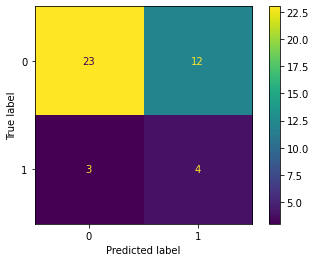

In [363]:
# import confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# get predictions and labels
preds_and_labels = RF_preds.select(['prediction','label']) \
                                  .withColumn('label', F.col('label').cast(FloatType())) \
                                  .orderBy('prediction') \
                                  .toPandas()

# get confusion matrix
cm = confusion_matrix(preds_and_labels["label"], preds_and_labels["prediction"], labels=[0, 1])
# get confusion matrix figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
# plot figure
disp.plot()
plt.show()

Calculate sensitivity and specificity

In [364]:
recall_sensitivity = metrics.recall_score(preds_and_labels["label"], preds_and_labels["prediction"], pos_label=1)
recall_specificity = metrics.recall_score(preds_and_labels["label"], preds_and_labels["prediction"], pos_label=0)
recall_sensitivity, recall_specificity 

(0.5714285714285714, 0.6571428571428571)

## 8.2 Model interpretation

We plot the future importance for the model with the highest AUC, this is the random forest model

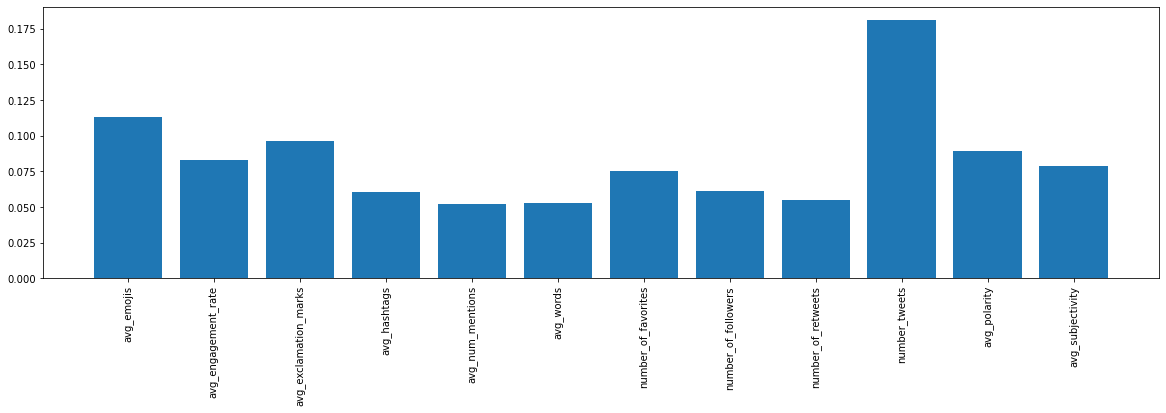

In [365]:
# inspect feature importance
feature_importance = RF_pipeline.stages[-1].featureImportances.toArray()
# define all the features
all_feature_names = numFeatureCols + ["avg_polarity", "avg_subjectivity"] 
plt.figure(figsize=(20, 5))
plt.bar(x=range(len(feature_importance)), height=feature_importance)
plt.xticks(range(len(feature_importance)), all_feature_names, rotation=90)
plt.show()

## 8.3 ROC Curve

We will plot the ROC curve for the model with the highest AUC, this is the random forest model.

We will use plotty to plot the ROC curve, so we will have to perform some data type transformations 

In [366]:
# convert the rf predictions to a pandas dataframe
RF_preds_pd = RF_preds.toPandas()
RF_preds_pd.head()

,avg_emojis,avg_engagement_rate,avg_exclamation_marks,avg_hashtags,avg_num_mentions,avg_polarity,avg_subjectivity,avg_words,dependent,number_of_favorites,number_of_followers,number_of_retweets,number_tweets,polarity,weight,label,featuresrf,rawPrediction,probability,prediction
0,0.734157,0.038621,0.366810,6.095596,0.460795,0.199685,0.424314,24.462406,0,17894,12151636,5673,1862,0.199685,0.654206,0.0,"[0.7341568206, 0.0386210277, 0.3668098818, 6.0...","[283.63039278242644, 116.36960721757352]","[0.7090759819560662, 0.2909240180439338]",0.0
1,0.848485,0.025601,0.368228,6.709826,0.370983,0.189519,0.399909,25.727273,0,11855,7174175,3734,1089,0.189519,0.654206,0.0,"[0.8484848485, 0.0256007015, 0.3682277319, 6.7...","[183.5977771473434, 216.40222285265665]","[0.45899444286835844, 0.5410055571316416]",1.0
2,0.781570,0.042334,0.411263,6.651877,0.295222,0.194657,0.404053,25.757679,0,1481,4034656,399,586,0.194657,0.654206,0.0,"[0.7815699659, 0.0423344081, 0.4112627986, 6.6...","[206.15010646243275, 193.84989353756728]","[0.5153752661560819, 0.4846247338439182]",0.0
3,0.809524,0.030810,0.364512,6.009070,0.397392,0.181159,0.416710,24.787982,0,14443,11905432,3897,1764,0.181159,0.654206,0.0,"[0.8095238095, 0.0308096354, 0.3645124717, 6.0...","[246.54809386395436, 153.45190613604572]","[0.6163702346598857, 0.38362976534011417]",0.0
4,0.746370,0.038572,0.296225,6.111326,0.356244,0.174242,0.417193,24.887706,1,9836,5287776,3585,1033,0.174242,2.121212,1.0,"[0.7463697967, 0.0385715167, 0.2962245886, 6.1...","[223.1378263966012, 176.86217360339882]","[0.557844565991503, 0.44215543400849705]",0.0


In [367]:
# this is a function that will select the probabilities for value 1
def select1(column):
    one = column[1]
    return one 

In [371]:
# we apply this function to our probabilities 
Yscore = RF_preds_pd['probability'].apply(lambda x: select1(x)).to_numpy()


In [372]:
# Yscore contains the probabilities of our predictions to be 1
Yscore

array([0.29092402, 0.54100556, 0.48462473, 0.38362977, 0.44215543,
       0.49100215, 0.62912221, 0.35355008, 0.43845924, 0.32533549,
       0.14169155, 0.42745808, 0.20410176, 0.19293489, 0.05364161,
       0.59831749, 0.72529535, 0.67596838, 0.6808029 , 0.27645269,
       0.18453612, 0.23038377, 0.70500848, 0.65926685, 0.56154233,
       0.41359839, 0.37274006, 0.7810226 , 0.68010243, 0.5174845 ,
       0.26344547, 0.61067371, 0.46559855, 0.46086465, 0.16539647,
       0.6006756 , 0.53739004, 0.36389687, 0.32100031, 0.472931  ,
       0.43972381, 0.54519512])

In [373]:
# Yscore is of the correct type to perform the plot 
type(Yscore)

numpy.ndarray

In [374]:
# Y is the real value of our dependent
Y = test.select('dependent').toPandas()
Y = Y['dependent'].to_numpy()
Y

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [375]:
# Yscore is of the correct type to perform the plot 
type(Y)

numpy.ndarray

In [376]:
# we use the roc_curve function to predict the false-positive, true-positive rate and thresholds based on the Y an Y score
fpr, tpr, thresholds = roc_curve(Y, Yscore)

In [377]:
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()